# Classifying Texts(NLP)

Text classification also known as text tagging is the process of categorizing text into organized groups. By using Natural Language Processing (NLP), text classifiers can automatically analyze text and then assign a set of pre-defined tags based on its content.

This notebook aims to give an overview of performing text classification using Support Vector Machines(SVM).

IMPORT LIBRARIES

In [4]:
import numpy as np
import pandas as pd
import matplotlib as mlp
import matplotlib.cm as cm
import plotly.graph_objects as go
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

import string
import re
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import metrics
from time import time
import warnings
warnings.filterwarnings("ignore")

UPLOADING AND ANALYSING DATA

In [6]:
df = pd.read_csv("/content/US-Economic-News.csv", encoding = "ISO-8859-1")

df.shape # Displays the number of rows and columns in the dataset

(8000, 15)

In [8]:
df.head(5) # Display first 5 rows of the dataset

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,positivity,positivity:confidence,relevance,relevance:confidence,articleid,date,headline,positivity_gold,relevance_gold,text
0,842613455,False,finalized,3,12/5/15 17:48,3.0,0.6400,yes,0.640,wsj_398217788,8/14/91,Yields on CDs Fell in the Latest Week,NaN,NaN,NEW YORK -- Yields on most certificates of dep...
1,842613456,False,finalized,3,12/5/15 16:54,NaN,NaN,no,1.000,wsj_399019502,8/21/07,The Morning Brief: White House Seeks to Limit ...,NaN,NaN,The Wall Street Journal Online</br></br>The Mo...
2,842613457,False,finalized,3,12/5/15 1:59,NaN,NaN,no,1.000,wsj_398284048,11/14/91,Banking Bill Negotiators Set Compromise --- Pl...,NaN,NaN,WASHINGTON -- In an effort to achieve banking ...
3,842613458,False,finalized,3,12/5/15 2:19,NaN,0.0000,no,0.675,wsj_397959018,6/16/86,Manager's Journal: Sniffing Out Drug Abusers I...,NaN,NaN,The statistics on the enormous costs of employ...
4,842613459,False,finalized,3,12/5/15 17:48,3.0,0.3257,yes,0.640,wsj_398838054,10/4/02,Currency Trading: Dollar Remains in Tight Rang...,NaN,NaN,NEW YORK -- Indecision marked the dollar's ton...


In [9]:
df["relevance"].value_counts()

,count
relevance,
no,6571
yes,1420
not sure,9


There is an imbalance in the data with not relevant being 82% in the dataset. That is, most of the articles are not relevant to US Economy, which makes sense in a real-world scenario, as news articles discuss various topics. We should keep this class imbalance mind when interpreting the classifier performance later. Let us first convert the class labels into binary outcome variables for convenience. 1 for Yes (relevant), and 0 for No (not relevant), and ignore "Not sure".

In [10]:
df = df[df.relevance != "not sure"]

df.shape

(7991, 15)

In [11]:
df["relevance"].value_counts() / df.shape[0]

,count
relevance,
no,0.8223
yes,0.1777


In [12]:
fig = go.Figure([go.Bar(x = df["relevance"].value_counts().index, y = df["relevance"].value_counts().tolist())])

fig.update_layout(
    title = "Value in each Sentiment",
    xaxis_title = "Sentiment",
    yaxis_title = "Values"

                )

fig.show()

TEXT PREPROCESING

In [13]:
df["relevance"] = df.relevance.map({"yes": 1, "no": 0})

df = df[["text", "relevance"]]  # taking text input and output variable as relevance

df = df[:1000]
df.shape


(1000, 2)

In [14]:
df.head(5)

,text,relevance
0,NEW YORK -- Yields on most certificates of dep...,1
1,The Wall Street Journal Online</br></br>The Mo...,0
2,WASHINGTON -- In an effort to achieve banking ...,0
3,The statistics on the enormous costs of employ...,0
4,NEW YORK -- Indecision marked the dollar's ton...,1


In [15]:
df["text"][0]

'NEW YORK -- Yields on most certificates of deposit offered by major banks dropped more than a tenth of a percentage point in the latest week, reflecting the overall decline in short-term interest rates.</br></br>On small-denomination, or "consumer," CDs sold directly by banks, the average yield on six-month deposits fell to 5.49% from 5.62% in the week ended yesterday, according to an 18-bank survey by Banxquote Money Markets, a Wilmington, Del., information service.</br></br>On three-month "consumer" deposits, the average yield sank to 5.29% from 5.42% the week before, according to Banxquote. Two banks in the Banxquote survey, Citibank in New York and CoreStates in Pennsylvania, are paying less than 5% on threemonth small-denomination CDs.</br></br>Declines were somewhat smaller on five-year consumer CDs, which eased to 7.37% from 7.45%, Banxquote said.</br></br>Yields on three-month and six-month Treasury bills sold at Monday\'s auction plummeted more than a fifth of a percentage po

TEXT CLEANING

Typical steps involve tokenization, lower casing, removing, stop words, punctuation markers etc, and vectorization. Other processes such as stemming/lemmatization can also be performed. Here, we are performing the following steps: removing br tags, punctuation, numbers, and stopwords. While we are using sklearn's list of stopwords, there are several other stop word lists (e.g., from NLTK) or sometimes, custom stopword lists are needed depending on the task.

In [23]:
import nltk
nltk.download("wordnet")
import spacy
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
nlp = spacy.load("en_core_web_sm")

stopwords = ENGLISH_STOP_WORDS
lemmatizer = WordNetLemmatizer()

def clean(doc):
  text_no_namentities = []
  document = nlp(doc)
  ents = [e.text for e in document.ents]
  for item in document:
    if item.text in ents:
      pass
    else:
      text_no_namentities.append(item.text)
  doc = (" ".join(text_no_namentities))

  doc = doc.lower().strip()
  doc = doc.replace("</br", " ")
  doc = doc.replace("-", " ")
  doc = "".join([char for char in doc if char not in string.punctuation and not char.isdigit()])

  doc = " ".join([token for token in doc.split() if token not in stopwords])

  doc = "".join([lemmatizer.lemmatize(word) for word in doc])

  return doc

[nltk_data] Downloading package wordnet to /root/nltk_data...


In [24]:
clean(df["text"][0])

'new york yields certificates deposit offered major banks dropped tenth percentage point latest week reflecting overall decline short term rates small denomination consumer cds sold directly banks average yield month deposits fell week ended yesterday according bank survey money markets information service month consumer deposits average yield sank week according banks survey new york paying small denomination cds declines somewhat smaller year consumer cds eased said yields month month bills sold s auction plummeted fifth percentage point previous week respectively'

In [25]:
df["text"] = df["text"].apply(clean)

In [26]:
df.head(5)

,text,relevance
0,new york yields certificates deposit offered m...,1
1,wall street journal online morning brief look ...,0
2,effort achieve banking reform negotiators admi...,0
3,statistics enormous costs employee drug abuse ...,0
4,new york indecision marked dollar s tone trade...,1




Now we are ready for the modeling. We are going to use algorithms from sklearn package. We will go through the following steps:

    1. Split the data into training and test sets (80% train, 20% test)

    2. Extract features from the training data using TfidfVectorizer.

    3. Transform the test data into the same feature vector as the training data.
    
    4. Train the classifier
    
    5. Evaluate the classifier



Term Frequency-Inverse Document Frequency, is a statistical method used in natural language processing and information retrieval to evaluate the importance of a word in a document relative to a collection of documents, known as a corpus.

Term Frequency (TF) measures how frequently a term appears in a document.

Inverse Document Frequency (IDF) measures how important a term is by considering how many documents contain the term across the corpus.

In [27]:
docs = list(df["text"])
tfidf_vectorizer = TfidfVectorizer(use_idf = True, max_features = 20000)

tfidf_vectorizer_vectors = tfidf_vectorizer.fit_transform(docs)

docs = tfidf_vectorizer_vectors.toarray()

In [28]:
x = docs

y = df["relevance"]

print(x.shape, y.shape)

(1000, 12552) (1000,)


In [30]:
fig = go.Figure([go.Bar(x = y.value_counts().index, y = y.value_counts().tolist())])

fig.update_layout(
    title = "Value in each Sentiment",
    xaxis_title = "Sentiment",
    yaxis_title = "Values")

fig.show()

TRAIN_TEST_SPLIT

In [31]:
SEED = 123
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = SEED, stratify = y)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(800, 12552) (800,)
(200, 12552) (200,)


SUPPORT VECTOR MACHINES

In [32]:
svc = LinearSVC(class_weight = "balanced")
%time svc.fit(x_train, y_train)

y_pred_train = svc.predict(x_train)
y_pred_test = svc.predict(x_test)

print("\nTraining Accuracy Score: ", accuracy_score(y_train, y_pred_train))

print("Testing Accuracy Score: ", accuracy_score(y_test, y_pred_test))

CPU times: user 84.7 ms, sys: 1.9 ms, total: 86.6 ms
Wall time: 197 ms

Training Accuracy Score:  1.0
Testing Accuracy Score:  0.73


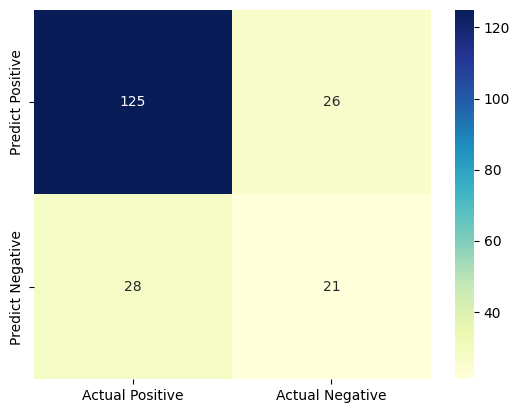

In [38]:
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred_test)

cm_matrix = pd.DataFrame(data = cm, columns = ["Actual Positive", "Actual Negative"],
                         index = ["Predict Positive", "Predict Negative"])

sns.heatmap(cm_matrix, annot = True, fmt = "d", cmap = "YlGnBu")

plt.show()

In [39]:
print(classification_report(y_test, y_pred_test, target_names = ["not relevant", "relevant"]))

              precision    recall  f1-score   support

not relevant       0.82      0.83      0.82       151
    relevant       0.45      0.43      0.44        49

    accuracy                           0.73       200
   macro avg       0.63      0.63      0.63       200
weighted avg       0.73      0.73      0.73       200



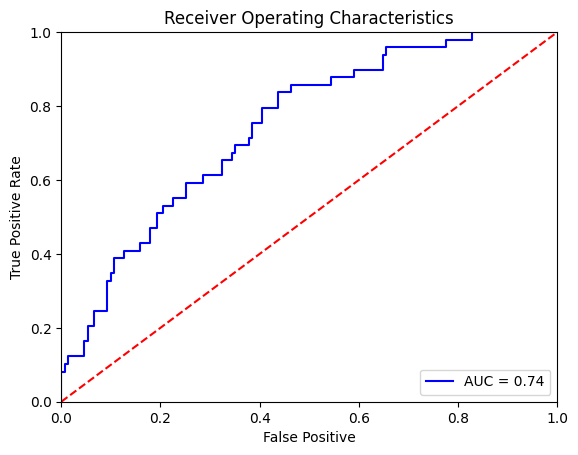

In [40]:
probs = svc._predict_proba_lr(x_test)
preds = probs[:, 1]

fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title("Receiver Operating Characteristics")
plt.plot(fpr, tpr, "b", label = "AUC = %0.2f" %roc_auc)

plt.legend(loc = "lower right")
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive")

plt.show()